# ADS proj -- School & Crime

In [200]:
from __future__ import print_function, division
import sys
import os
import numpy as np
import pylab as pl
#importing pandas for reading and parsing of tabulated data
import pandas as pd
#importing geopandas read to plot geographical information
import geopandas as gpd
#importing fiona to handle geographical coordinates
import fiona
#import shapely to handle geographical shapes
import shapely
import json
import requests 
import urllib

import seaborn as sns
sns.set_style('whitegrid')
%pylab inline

import statsmodels.formula.api as smf
from IPython.display import HTML

Populating the interactive namespace from numpy and matplotlib


In [201]:
PUIDATA = os.getenv('PUIDATA')
print(PUIDATA)

/home/cusp/dcr346/PUIdata


## Read in School shapefile (points)

In [202]:
schoolshp = gpd.GeoDataFrame.from_file(PUIDATA +"/Public_Schools_Points_2011-2012A.shp")
#schoolshp.crs = from_epsg(2263) 
schoolshp.head()

,ATS_CODE,BORO,BORONUM,LOC_CODE,SCHOOLNAME,SCH_TYPE,MANAGED_BY,GEO_DISTRI,ADMIN_DIST,ADDRESS,STATE_CODE,ZIP,PRINCIPAL,PRIN_PH,FAX,GRADES,City,geometry
0,15K001,K,2.0,K001,P.S. 001 THE BERGEN,Elementary,1,15,15,309 47 STREET,NY,11220,Jennifer Eusanio,718-567-7661,718-567-9771,"PK,0K,01,02,03,04,05,SE",BROOKLYN,POINT (980985.0541713729 175780.758994163)
1,17K002,K,2.0,K002,M.S. 002,Junior High-Intermediate-Middle,1,17,17,655 PARKSIDE AVENUE,NY,11226,ADRIENNE SPENCER,718-462-6992,718-284-7717,"06,07,08,SE",BROOKLYN,POINT (997785.1364296663 178431.910832498)
2,21K095,K,2.0,K095,P.S. 095 THE GRAVESEND,K-8,1,21,21,345 VAN SICKLEN STREET,NY,11223,Janet Ndzibah,718-449-5050,718-449-3047,"PK,0K,01,02,03,04,05,06,07,08,SE",BROOKLYN,POINT (991224.9830063033 156323.3612131244)
3,21K096,K,2.0,K096,I.S. 096 SETH LOW,Junior High-Intermediate-Middle,1,21,21,99 AVENUE P,NY,11204,Denise Sandra Levinsky,718-236-1344,718-236-2397,"06,07,08,SE",BROOKLYN,POINT (988439.6813609767 160709.9926236183)
4,21K097,K,2.0,K097,P.S. 97 THE HIGHLAWN,Elementary,1,21,21,1855 STILLWELL AVENUE,NY,11223,KRISTINE MUSTILLO,718-372-7393,718-372-3842,"PK,0K,01,02,03,04,05,SE",BROOKLYN,POINT (988205.0729096507 158329.5913366843)


In [203]:
schoolshp.dtypes

ATS_CODE       object
BORO           object
BORONUM       float64
LOC_CODE       object
SCHOOLNAME     object
SCH_TYPE       object
MANAGED_BY      int64
GEO_DISTRI      int64
ADMIN_DIST      int64
ADDRESS        object
STATE_CODE     object
ZIP             int64
PRINCIPAL      object
PRIN_PH        object
FAX            object
GRADES         object
City           object
geometry       object
dtype: object

In [204]:
schoolshp.shape

(1709, 18)

## Read in PUMA shapefile

In [205]:
url = 'https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data'

In [206]:
urllib.request.urlretrieve(url, "puma.gz")
os.system("unzip -d %s puma.zip"%(os.getenv('PUIDATA')))

2304

In [207]:
pumashp = gpd.GeoDataFrame.from_file(PUIDATA + '/geo_export_3ec730a2-fc45-4924-aa8f-a1d3f9b4c746.shp')
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


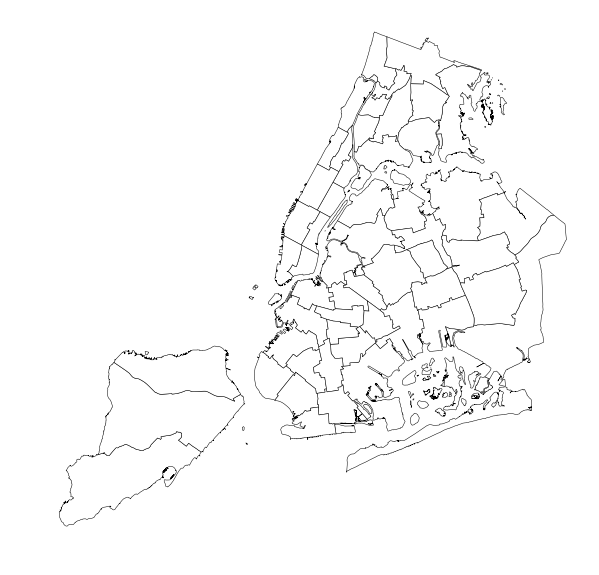

In [208]:
# using a choroplethNYC function that FBB wrote
import choroplethNYC as cp
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=.5);

In [209]:
pumashp.shape

(55, 4)

## Read in School Progress Data

In [210]:
#schoolprog = pd.DataFrame.from_csv(PUIDATA + '/2007_-_2011_School_Progress_Report_Multi-year.csv')
#schoolprog.head()

In [211]:
schools2007 = pd.read_excel("http://schools.nyc.gov/NR/rdonlyres/CA6CD49D-E595-4272-B594-385A6A3229A3/0/2007ProgressReportResults_011409.xls", skiprows=0)
schools2013 = pd.read_excel("http://schools.nyc.gov/NR/rdonlyres/1550033E-3F15-4746-BD1A-DF3364721785/0/2012_2013_EMS_PR_Results_2014_04_24.xlsx", skiprows=1)

## Cleaning 2007 data

In [212]:
schools2007 = schools2007.dropna(0)
#schools2007 = schools2007.reset_index()

In [213]:
columns = (np.asarray(schools2007.iloc[:1,:]))
schools2007.columns = columns[0]
schools2007 =  schools2007.iloc[1:,:]

schools2007.head()

,DBN,DISTRICT,SCHOOL,SCHOOL SUPPORT ORGANIZATION/NETWORK,PROGRESS REPORT TYPE,SCHOOL LEVEL*,PEER INDEX*,GRADE,OVERALL SCORE,ENVIRONMENT CATEGORY SCORE,PERFORMANCE CATEGORY SCORE,PROGRESS CATEGORY SCORE,ADDITIONAL CREDIT,QUALITY REVIEW SCORE
NaN,01M015,01,PS 015 ROBERTO CLEMENTE,ICI15,ESMS,Elementary School,75.6,B,52.31,0.278,0.231,0.694,3,Undeveloped
NaN,01M019,01,PS 019 ASHER LEVY,ESO1,ESMS,Elementary School,59.25,B,51.24,0.51,0.466,0.511,1.5,Proficient
NaN,01M020,01,PS 020 ANNA SILVER,ICI15,ESMS,Elementary School,69.78,B,52.59,0.568,0.682,0.402,1.5,Well-Developed
NaN,01M034,01,PS 034 FRANKLIN D ROOSEVELT,ICI15,ESMS,K-8 School,71.9,C,47.02,0.409,0.366,0.53,0.75,Proficient
NaN,01M063,01,PS 063 WILLIAM MCKINLEY,ICI15,ESMS,Elementary School,62.17,C,44.66,0.199,0.511,0.479,0,Proficient


In [214]:
schools2007['Rating'] = schools2007['GRADE'].map({'A': 5, 'B': 4,'C':3,'D':2,'F':1})

In [215]:
schools2007 = schools2007[['DBN','SCHOOL','SCHOOL LEVEL*','Rating']]
schools2007.head()

,DBN,SCHOOL,SCHOOL LEVEL*,Rating
NaN,01M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0
NaN,01M019,PS 019 ASHER LEVY,Elementary School,4.0
NaN,01M020,PS 020 ANNA SILVER,Elementary School,4.0
NaN,01M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0
NaN,01M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0


In [216]:
schools2007.columns = ['DBN','SchoolName','SchoolType','Rating']
schools2007.head()

,DBN,SchoolName,SchoolType,Rating
NaN,01M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0
NaN,01M019,PS 019 ASHER LEVY,Elementary School,4.0
NaN,01M020,PS 020 ANNA SILVER,Elementary School,4.0
NaN,01M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0
NaN,01M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0


In [217]:
schools2007['DBN'] = schools2007['DBN'].str[2:]
schools2007.head()

,DBN,SchoolName,SchoolType,Rating
NaN,M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0
NaN,M019,PS 019 ASHER LEVY,Elementary School,4.0
NaN,M020,PS 020 ANNA SILVER,Elementary School,4.0
NaN,M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0
NaN,M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0


In [218]:
schools2007.shape

(1224, 4)

In [219]:
schools2007.to_csv('schools2007.csv')

## Cleaning 2013 data

In [220]:
schools2013['Rating'] = schools2013['Overall Grade'].map({'A': 5, 'B': 4,'C':3,'D':2,'F':1})
schools2013 = schools2013[['DBN','School Name','School Type','Rating']]
schools2013.columns = ['DBN','SchoolName','SchoolType','Rating']
schools2013['DBN'] = schools2013['DBN'].str[2:]
schools2013.head()

,DBN,SchoolName,SchoolType,Rating
0,M015,P.S. 015 Roberto Clemente,Elementary,3.0
1,M019,P.S. 019 Asher Levy,Elementary,5.0
2,M020,P.S. 020 Anna Silver,Elementary,4.0
3,M034,P.S. 034 Franklin D. Roosevelt,K-8,5.0
4,M063,The STAR Academy - P.S.63,Elementary,3.0


In [221]:
schools2013.shape

(1198, 4)

In [222]:
schools2013.to_csv('schools2013.csv')

## Merge School scores w School shp

## 2007

In [223]:
schools2007 = schools2007.merge(schoolshp, left_on='DBN', right_on='LOC_CODE')
schools2007.head()

,DBN,SchoolName,SchoolType,Rating,ATS_CODE,BORO,BORONUM,LOC_CODE,SCHOOLNAME,SCH_TYPE,...,ADMIN_DIST,ADDRESS,STATE_CODE,ZIP,PRINCIPAL,PRIN_PH,FAX,GRADES,City,geometry
0,M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0,01M015,M,1.0,M015,P.S. 015 ROBERTO CLEMENTE,Elementary,...,1,333 EAST 4 STREET,NY,10009,IRENE SANCHEZ,212-228-8730,212-477-0931,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (990123.2547304605 202281.6311154864)
1,M019,PS 019 ASHER LEVY,Elementary School,4.0,01M019,M,1.0,M019,P.S. 019 ASHER LEVY,Elementary,...,1,185 1 AVENUE,NY,10003,JACQUELINE FLANAGAN,212-533-5340,212-673-1477,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (988634.7054615917 205140.7731699182)
2,M020,PS 020 ANNA SILVER,Elementary School,4.0,01M020,M,1.0,M020,P.S. 020 ANNA SILVER,Elementary,...,1,166 ESSEX STREET,NY,10002,JAMES LEE,212-254-9577,212-254-3526,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (988025.1479657721 202056.5849334946)
3,M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0,01M034,M,1.0,M034,P.S. 034 FRANKLIN D. ROOSEVELT,K-8,...,1,730 EAST 12 STREET,NY,10009,JOYCE STALLINGS HARTE,212-228-4433,212-353-1973,"PK,0K,01,02,03,04,05,06,07,08,SE",MANHATTAN,POINT (991118.12310576 203875.9493196165)
4,M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0,01M063,M,1.0,M063,P.S. 063 WILLIAM MCKINLEY,Elementary,...,1,121 EAST 3 STREET,NY,10009,DARLENE DESPEIGNES,212-674-3180,212-420-9018,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (988036.345197865 203208.4555002286)


In [224]:
schools2007.shape

(1201, 22)

In [225]:
schools2007.columns

Index(['DBN', 'SchoolName', 'SchoolType', 'Rating', 'ATS_CODE', 'BORO',
       'BORONUM', 'LOC_CODE', 'SCHOOLNAME', 'SCH_TYPE', 'MANAGED_BY',
       'GEO_DISTRI', 'ADMIN_DIST', 'ADDRESS', 'STATE_CODE', 'ZIP', 'PRINCIPAL',
       'PRIN_PH', 'FAX', 'GRADES', 'City', 'geometry'],
      dtype='object')

In [226]:
schools2007 =  schools2007[['DBN','SchoolName','SchoolType','Rating', 'BORO', 'ZIP','geometry']]
schools2007.head()

,DBN,SchoolName,SchoolType,Rating,BORO,ZIP,geometry
0,M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0,M,10009,POINT (990123.2547304605 202281.6311154864)
1,M019,PS 019 ASHER LEVY,Elementary School,4.0,M,10003,POINT (988634.7054615917 205140.7731699182)
2,M020,PS 020 ANNA SILVER,Elementary School,4.0,M,10002,POINT (988025.1479657721 202056.5849334946)
3,M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0,M,10009,POINT (991118.12310576 203875.9493196165)
4,M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0,M,10009,POINT (988036.345197865 203208.4555002286)


## 2013

In [227]:
schools2013 = schools2013.merge(schoolshp, left_on='DBN', right_on='LOC_CODE')
schools2013.head(3)

,DBN,SchoolName,SchoolType,Rating,ATS_CODE,BORO,BORONUM,LOC_CODE,SCHOOLNAME,SCH_TYPE,...,ADMIN_DIST,ADDRESS,STATE_CODE,ZIP,PRINCIPAL,PRIN_PH,FAX,GRADES,City,geometry
0,M015,P.S. 015 Roberto Clemente,Elementary,3.0,01M015,M,1.0,M015,P.S. 015 ROBERTO CLEMENTE,Elementary,...,1,333 EAST 4 STREET,NY,10009,IRENE SANCHEZ,212-228-8730,212-477-0931,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (990123.2547304605 202281.6311154864)
1,M019,P.S. 019 Asher Levy,Elementary,5.0,01M019,M,1.0,M019,P.S. 019 ASHER LEVY,Elementary,...,1,185 1 AVENUE,NY,10003,JACQUELINE FLANAGAN,212-533-5340,212-673-1477,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (988634.7054615917 205140.7731699182)
2,M020,P.S. 020 Anna Silver,Elementary,4.0,01M020,M,1.0,M020,P.S. 020 ANNA SILVER,Elementary,...,1,166 ESSEX STREET,NY,10002,JAMES LEE,212-254-9577,212-254-3526,"PK,0K,01,02,03,04,05,SE",MANHATTAN,POINT (988025.1479657721 202056.5849334946)


In [228]:
schools2013.shape

(1181, 22)

In [229]:
schools2013 =  schools2013[['DBN','SchoolName','SchoolType','Rating', 'BORO', 'ZIP','geometry']]
schools2013.head()

,DBN,SchoolName,SchoolType,Rating,BORO,ZIP,geometry
0,M015,P.S. 015 Roberto Clemente,Elementary,3.0,M,10009,POINT (990123.2547304605 202281.6311154864)
1,M019,P.S. 019 Asher Levy,Elementary,5.0,M,10003,POINT (988634.7054615917 205140.7731699182)
2,M020,P.S. 020 Anna Silver,Elementary,4.0,M,10002,POINT (988025.1479657721 202056.5849334946)
3,M034,P.S. 034 Franklin D. Roosevelt,K-8,5.0,M,10009,POINT (991118.12310576 203875.9493196165)
4,M063,The STAR Academy - P.S.63,Elementary,3.0,M,10009,POINT (988036.345197865 203208.4555002286)


# Spatial Join (.sjoin) with PUMA shp (point+polygons)

## 2007

In [230]:
type(schools2007)

pandas.core.frame.DataFrame

In [231]:
#from geopandas import GeoDataFrame
#from shapely.geometry import Point

#geometry = [Point(xy) for xy in zip(df.Lon, df.Lat)]
#df = df.drop(['Lon', 'Lat'], axis=1)
crs = {'init': 'epsg:2263'}
schools2007 = gpd.GeoDataFrame(schools2007, crs=crs, geometry=schools2007.geometry)
type(schools2007)

geopandas.geodataframe.GeoDataFrame

In [232]:
schools2007.head()

,DBN,SchoolName,SchoolType,Rating,BORO,ZIP,geometry
0,M015,PS 015 ROBERTO CLEMENTE,Elementary School,4.0,M,10009,POINT (990123.2547304605 202281.6311154864)
1,M019,PS 019 ASHER LEVY,Elementary School,4.0,M,10003,POINT (988634.7054615917 205140.7731699182)
2,M020,PS 020 ANNA SILVER,Elementary School,4.0,M,10002,POINT (988025.1479657721 202056.5849334946)
3,M034,PS 034 FRANKLIN D ROOSEVELT,K-8 School,3.0,M,10009,POINT (991118.12310576 203875.9493196165)
4,M063,PS 063 WILLIAM MCKINLEY,Elementary School,3.0,M,10009,POINT (988036.345197865 203208.4555002286)


In [233]:
schools2007.crs

{'init': 'epsg:2263'}

In [234]:
pumashp.crs

{'init': 'epsg:4326'}

In [235]:
pumashp = pumashp.to_crs({'init': 'epsg:2263'})
pumashp.crs

{'init': 'epsg:2263'}

In [236]:
schools2007g = gpd.sjoin(schools2007, pumashp, how='inner', op='within')
schools2007g.head()

,DBN,SchoolName,SchoolType,Rating,BORO,ZIP,geometry,index_right,puma,shape_leng,shape_area
396,X307,EAMES PLACE (P.S.307),Elementary School,5.0,X,10468,POINT (1011441.883968057 255954.5619534563),0,3701,53227.144376,9.792852e+07
401,X340,PS 340,Elementary School,4.0,X,10468,POINT (1012674.011965437 255963.4726108323),0,3701,53227.144376,9.792852e+07
372,X086,PS 086 KINGSBRIDGE HEIGHTS,Elementary School,5.0,X,10468,POINT (1012385.25224769 256185.0749038415),0,3701,53227.144376,9.792852e+07
402,X342,INTERNATIONAL SCHOOL OF LIBERAL ARTS,Middle School,4.0,X,10468,POINT (1012546.720579609 256392.6970082848),0,3701,53227.144376,9.792852e+07
425,X549,DISCOVERY HIGH SCHOOL,High School,4.0,X,10468,POINT (1012755.37051009 256396.3899274084),0,3701,53227.144376,9.792852e+07


In [237]:
schools2007g.shape

(1201, 11)

In [238]:
schools2007g = schools2007g.groupby([schools2007g['puma']]).mean()
schools2007g = schools2007g[['Rating']]
#schools2007g['Rating'] = schools2007g['Rating'].str[:4]
schools2007g.columns = ['Rating07']
schools2007g.head()

,Rating07
puma,
3701,4.192308
3702,3.555556
3703,3.714286
3704,3.800000
3705,3.569231


## 2013

In [239]:
crs = {'init': 'epsg:2263'}
schools2013 = gpd.GeoDataFrame(schools2013, crs=crs, geometry=schools2013.geometry)
type(schools2013)

geopandas.geodataframe.GeoDataFrame

In [240]:
schools2013.head()

,DBN,SchoolName,SchoolType,Rating,BORO,ZIP,geometry
0,M015,P.S. 015 Roberto Clemente,Elementary,3.0,M,10009,POINT (990123.2547304605 202281.6311154864)
1,M019,P.S. 019 Asher Levy,Elementary,5.0,M,10003,POINT (988634.7054615917 205140.7731699182)
2,M020,P.S. 020 Anna Silver,Elementary,4.0,M,10002,POINT (988025.1479657721 202056.5849334946)
3,M034,P.S. 034 Franklin D. Roosevelt,K-8,5.0,M,10009,POINT (991118.12310576 203875.9493196165)
4,M063,The STAR Academy - P.S.63,Elementary,3.0,M,10009,POINT (988036.345197865 203208.4555002286)


In [241]:
schools2013g = gpd.sjoin(schools2013, pumashp, how='inner', op='within')
schools2013g.head()

,DBN,SchoolName,SchoolType,Rating,BORO,ZIP,geometry,index_right,puma,shape_leng,shape_area
341,X307,Luisa Pineiro Fuentes School of Science and Di...,Elementary,5.0,X,10468,POINT (1011441.883968057 255954.5619534563),0,3701,53227.144376,9.792852e+07
346,X340,P.S. 340,Elementary,5.0,X,10468,POINT (1012674.011965437 255963.4726108323),0,3701,53227.144376,9.792852e+07
321,X086,P.S. 086 Kingsbridge Heights,Elementary,5.0,X,10468,POINT (1012385.25224769 256185.0749038415),0,3701,53227.144376,9.792852e+07
347,X342,International School for Liberal Arts,Middle,5.0,X,10468,POINT (1012546.720579609 256392.6970082848),0,3701,53227.144376,9.792852e+07
349,X360,P.S. 360,Elementary,3.0,X,10463,POINT (1011283.377664369 257987.5970700345),0,3701,53227.144376,9.792852e+07


In [242]:
schools2013g = schools2013g.groupby([schools2013g['puma']]).mean()
schools2013g = schools2013g[['Rating']]
schools2013g.columns = ['Rating13']
schools2013g.head()

,Rating13
puma,
3701,4.357143
3702,3.166667
3703,3.529412
3704,3.692308
3705,3.727273


## Merging two dataframes of 2007 & 2013, than merging with PUMA GeoDataFrame again

In [243]:
# merge 07 + 13 

schoolspuma = schools2007g.merge(schools2013g, left_index=True, right_index=True)
schoolspuma['RatingChange07-13'] = schoolspuma['Rating13'] / schoolspuma['Rating07']
schoolspuma.head()

,Rating07,Rating13,RatingChange07-13
puma,,,
3701,4.192308,4.357143,1.039318
3702,3.555556,3.166667,0.890625
3703,3.714286,3.529412,0.950226
3704,3.800000,3.692308,0.971660
3705,3.569231,3.727273,1.044279


In [244]:
# merge with puma shp

schoolspuma = schoolspuma.merge(pumashp, left_index=True, right_on='puma')
schoolspuma = schoolspuma.set_index('puma')
schoolspuma

,Rating07,Rating13,RatingChange07-13,shape_leng,shape_area,geometry
puma,,,,,,
3701,4.192308,4.357143,1.039318,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,..."
3702,3.555556,3.166667,0.890625,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,..."
3703,3.714286,3.529412,0.950226,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...
3704,3.800000,3.692308,0.971660,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,..."
3705,3.569231,3.727273,1.044279,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,..."
3706,3.933333,3.866667,0.983051,51799.404764,4.388687e+07,"POLYGON ((1008237.008422854 252471.6857909637,..."
3707,3.875000,3.866667,0.997849,37347.926177,4.228113e+07,"POLYGON ((1008237.008422854 252471.6857909637,..."
3708,3.620690,3.518519,0.971781,34853.551314,5.589653e+07,"POLYGON ((1005060.892822267 247052.5200194765,..."
3709,3.387097,3.750000,1.107143,73289.990781,1.241170e+08,"(POLYGON ((1029456.00079346 237188.9177855959,..."


In [245]:
crs = {'init': 'epsg:2263'}
schoolspuma = gpd.GeoDataFrame(schoolspuma, crs=crs, geometry=schoolspuma.geometry)

In [246]:
schoolspuma.to_csv('schoolspuma.csv')

# Plot School Ratings by PUMA

(None,
 <matplotlib.legend.Legend at 0x7f2b26af63c8>)

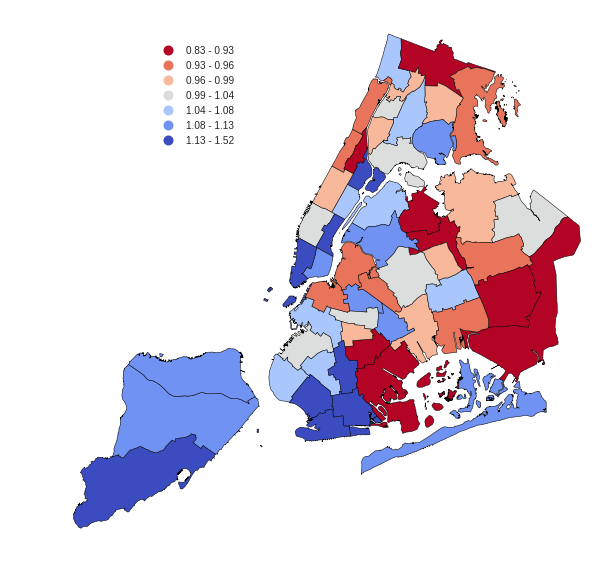

In [247]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cp.choroplethNYC(schoolspuma, column='RatingChange07-13', cmap='coolwarm_r', scheme='Quantiles', k=7, edgecolor='k', lw=.5, ax=ax)

#x = linkNYC.longitude;
#y = linkNYC.latitude;
#c = linkNYC.Date
#scatter(x,y,4,c, cmap='Reds')

# Reading in Crime Data